In [1]:
# here is how we activate an environment in our current directory
import Pkg; Pkg.activate(@__DIR__)

# instantate this environment (download packages if you haven't)
Pkg.instantiate();

using Test, LinearAlgebra
import ForwardDiff as FD 
import FiniteDiff as FD2 
using Plots

  Activating project at `~/Desktop/16-745 OCRL/16745-Optimal-Control-and-RL/HW0_S24-main`


# Q2: Newton's Method (20 pts)

## Part (a): Newton's method in 1 dimension (8pts)
First let's look at a nonlinear function, and label where this function is equal to 0 (a root of the function).

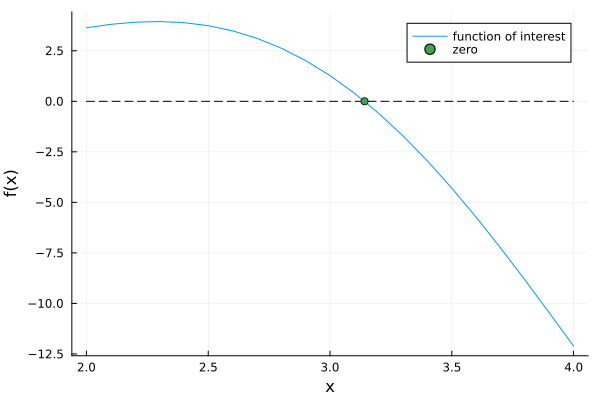

In [3]:
let
	x = 2:0.1:4
	y = sin.(x) .* x .^ 2

	plot(x, y, label = "function of interest")
	plot!(x, 0 * x, linestyle = :dash, color = :black, label = "")

	xlabel!("x")
	ylabel!("f(x)")

	scatter!([pi], [0], label = "zero") # adds a scatter plot point at (π ,0) and labels it as "zero
    
end


We are now going to use Newton's method to numerically evaluate the argument $x$ where this function is equal to zero. To make this more general, let's define a residual function,
$$ r(x) = \sin(x)x^2. $$
We want to drive this residual function to be zero (aka find a root to $r(x)$). To do this, we start with an initial guess at $x_k$, and approximate our residual function with a first-order Taylor expansion:
$$ r(x_k + \Delta x) \approx r(x_k) + \bigg[ \frac{\partial r}{\partial x}\bigg\rvert_{x_k} \bigg] \Delta x. $$ 
We now want to find the root of this linear approximation. In other words, we want to find a $\Delta x$ such that $r(x_k + \Delta x) = 0$. To do this, we simply re-arrange:
$$ \Delta x = -\bigg[ \frac{\partial r}{\partial x}\bigg\rvert_{x_k} \bigg]^{-1}r(x_k). $$ 
We can now increment our estimate of the root with the following:
$$ x_{k+1} = x_k + \Delta x$$
We have now described one step of Netwon's method. We started with an initial point, linearized the residual function, and solved for the $\Delta x$ that drove this linear approximation to zero. We keep taking Newton steps until $r(x_k)$ is close enough to zero for our purposes (usually not hard to drive below 1e-10). 


Julia tip: `x=A\b` solves linear systems of the form $Ax = b$ whether $A$ is a matrix or a scalar. 

In [11]:
"""
    X = newtons_method_1d(x0, residual_function; max_iters)

Given an initial guess x0::Float64, and `residual_function`, 

use Newton's method to calculate the zero that makes residual_function(x) ≈ 0. 

Store your iterates in a vector X and return X[1:i]. 
(first element of the returned vector should be x0, last element should be the solution)
"""

function newtons_method_1d(x0::Float64, residual_function::Function; max_iters = 10)::Vector{Float64}
    # return the history of iterates as a 1d vector (Vector{Float64})
    # consider convergence to be when abs(residual_function(X[i])) < 1e-10 
    # at this point, trim X to be X = X[1:i], and return X 

    X = zeros(max_iters)
    X[1] = x0 
    
    for i = 1:max_iters 
        
        # TODO: Newton's method here
        X[i+1] = X[i] - residual_function(X[i]) / FD.derivative(residual_function, X[i])
        
        # return the trimmed X[1:i] after you converge 
        if abs(residual_function(X[i])) < 1e-10
            return X[1:i]
        end

    end
    error("Newton did not converge")
end

newtons_method_1d (generic function with 1 method)

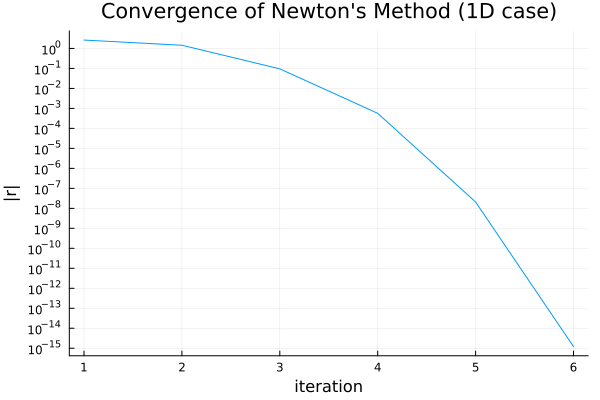

Test Summary: | Pass  Total  Time
2a            |    1      1  0.5s


Test.DefaultTestSet("2a", Any[], 1, false, false, true, 1.722927373582065e9, 1.722927374055539e9, false, "In[12]")

In [12]:
@testset "2a" begin
    # residual function 
    residual_fx(_x) = sin(_x)*_x^2
    
    x0 = 2.8 
    X = newtons_method_1d(x0, residual_fx; max_iters = 10)
    R = residual_fx.(X) # the . evaluates the function at each element of the array
    
    @test abs(R[end]) < 1e-10
    
    # plotting
    display(plot(abs.(R),yaxis=:log,ylabel = "|r|",xlabel = "iteration",
         yticks= [1.0*10.0^(-x) for x = float(15:-1:-2)],
         title = "Convergence of Newton's Method (1D case)",label = ""))
    
end

## Part (b): Newton's method in multiple variables (8 pts)
We are now going to use Newton's method to solve for the zero of a multivariate function.

In [67]:
"""
    X = newtons_method(x0, residual_function; max_iters)

Given an initial guess x0::Vector{Float64}, and `residual_function`, 

use Newton's method to calculate the zero that makes norm(residual_function(x)) ≈ 0. 

Store your iterates in a vector X and return X[1:i]. 
(first element of the returned vector should be x0, last element should be the solution)
"""

function newtons_method(x0::Vector{Float64}, residual_function::Function; max_iters = 10)::Vector{Vector{Float64}}
    # return the history of iterates as a vector of vectors (Vector{Vector{Float64}})
    # consider convergence to be when norm(residual_function(X[i])) < 1e-10 
    # at this point, trim X to be X = X[1:i], and return X 

    X = [zeros(length(x0)) for i = 1:max_iters+1]
    X[1] = x0 
    
    for i = 1:max_iters 
        # @show i;
        # @show X[i];

        # TODO: Newton's method here
        Jx = FD.jacobian(residual_function, X[i])
        
        # Add regularization to the diagonal of the Jacobian
        ε = 1e-8
        Jx += ε * I(size(Jx, 1))
        
        Fx = residual_function(X[i])
        
        Δx = Jx \ Fx  # Solve Jx * Δx = Fx
        X[i+1] = X[i] - Δx

        # return the trimmed X[1:i] after you converge 
        if norm(residual_function(X[i])) < 1e-10
            return X[1:i]
        end
        
        # @show i;
        # @show X[i+1];
    end
    error("Newton did not converge")
end

newtons_method (generic function with 1 method)

length(x0) = 4
length(X) = 10
length(R) = 10
Rp[1] = [0.3574728726327714, 0.00714316906252992, 0.00015931100676684629, 1.0020448922617303e-7, 3.530942899176992e-14, 2.6020852139652106e-17, 8.673617379884035e-19, 2.6020852139652106e-18, 0.0, 2.6020852139652106e-18]


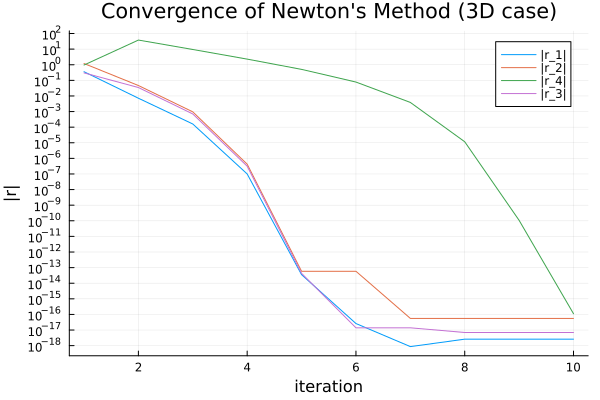

Test Summary: | Pass  Total  Time
2b            |    1      1  0.3s


Test.DefaultTestSet("2b", Any[], 1, false, false, true, 1.722930431604487e9, 1.722930431935563e9, false, "In[139]")

In [139]:
@testset "2b" begin
	# residual function 
	r(x) = [sin(x[3] + 0.3) * cos(x[2] - 0.2) - 0.3 * x[1];
		cos(x[1]) + sin(x[2]) + tan(x[3]);
		3 * x[1] + 0.1 * x[2]^3;
        x[1]^2 + x[2]^2 + x[3]^2 + x[4]^2 - 1;
	]

	x0 = [0.1; 0.1; 0.1; 0.1]
	@show length(x0)

	X = newtons_method(x0, r; max_iters = 20)
	@show length(X)

	R = r.(X) # the . evaluates the function at each element of the array
	@show length(R)

	Rp = [[abs(R[i][ii]) for i ∈ 1:length(R)] for ii ∈ 1:4] # this gets abs of each term at each iteration

	# tests 
	@test norm(R[end]) < 1e-10

    @show Rp[1]
    function replace_zeros_with_previous(data)
        """
        Replace zeros with the last non-zero value in the array
        to prevent log(0) from causing issues in the plot
        """
        result = similar(data)
        last_non_zero = 0.0
        
        for i in 1:length(data)
            if data[i] == 0.0
                result[i] = last_non_zero
            else
                result[i] = data[i]
                last_non_zero = data[i]
            end
        end
        
        return result
    end

    Rp = [replace_zeros_with_previous(Rp[i]) for i in 1:4]

	# convergence plotting 
	plot(Rp[1], yaxis = :log, ylabel = "|r|", xlabel = "iteration",
		yticks = [1.0 * 10.0^(-x) for x ∈ float(18:-1:-2)],
		title = "Convergence of Newton's Method (3D case)", label = "|r_1|")

	plot!(Rp[2], label = "|r_2|")
	plot!(Rp[4], label = "|r_4|")

	display(plot!(Rp[3], label = "|r_3|"))



end


## Part (c): Newtons method in optimization (4 pt)
Now let's look at how we can use Newton's method in numerical optimization. Let's start by plotting a cost function $f(x)$, where $x\in \mathbb{R}^2$.

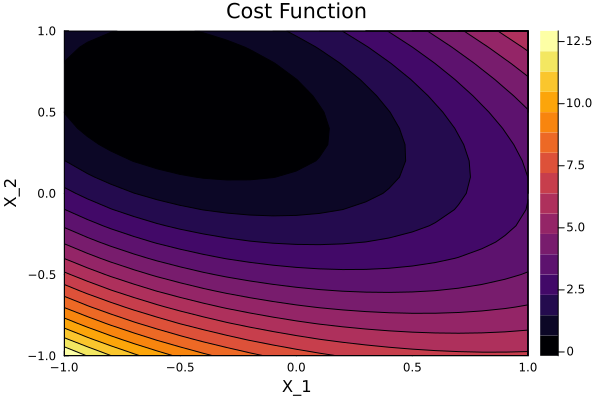

In [143]:
let
    Q = [1.65539 2.89376; 2.89376 6.51521]
    q = [2; -3]

    f(x) = 0.5 * x' * Q * x + q' * x + exp(-1.3 * x[1] + 0.3 * x[2]^2) # cost function 

    contour(-1:0.1:1, -1:0.1:1, (x1, x2) -> f([x1; x2]), title="Cost Function",
        xlabel="X_1", ylabel="X_2", fill=true)
end

To find the minimum for this cost function $f(x)$, let's write the KKT conditions for optimality:


$$ \nabla f(x) = 0 \quad \quad \text{stationarity}, $$


which we see is just another rootfinding problem. We are now going to use Newton's method on the KKT conditions to find the $x$ in which $\nabla f(x) = 0$.  

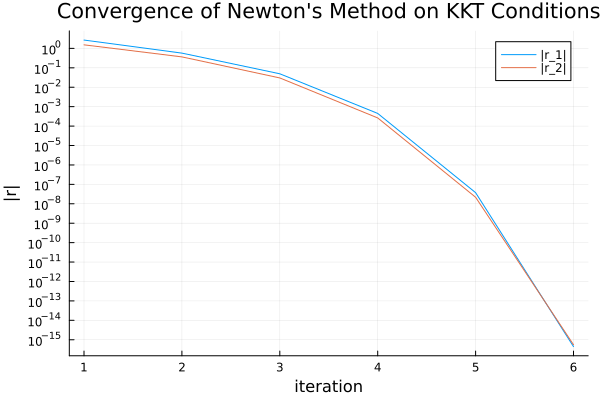

Test Summary: | Pass  Total  Time
2c            |    1      1  0.9s


Test.DefaultTestSet("2c", Any[], 1, false, false, true, 1.722931178297931e9, 1.722931179155725e9, false, "In[163]")

In [163]:
Rp_global = []

@testset "2c" begin
    Q = [1.65539 2.89376; 2.89376 6.51521]
    q = [2; -3]

    f(x) = 0.5 * x' * Q * x + q' * x + exp(-1.3 * x[1] + 0.3 * x[2]^2)

    function kkt_conditions(x)
        # TODO: return the stationarity condition for the cost function f (∇f(x))

        # hint: use forward diff
        ∇f = FD.gradient(f, x)
        return ∇f

    end

    # Calls kkt_conditions to get the gradient, which serves as the residual for Newton's method.
    residual_fx(_x) = kkt_conditions(_x)

    x0 = [-0.9512129986081451, 0.8061342694354091]

    X = newtons_method(x0, residual_fx; max_iters=10)
    R = residual_fx.(X) # the . evaluates the function at each element of the array

    Rp = [[abs(R[i][ii]) for i = 1:length(R)] for ii = 1:length(R[1])] # this gets abs of each term at each iteration

    # tests 
    @test norm(R[end]) < 1e-10

    plot(Rp[1], yaxis=:log, ylabel="|r|", xlabel="iteration",
        yticks=[1.0 * 10.0^(-x) for x = float(15:-1:-2)],
        title="Convergence of Newton's Method on KKT Conditions", label="|r_1|")
    display(plot!(Rp[2], label="|r_2|"))

    global Rp_global
    Rp_global = Rp

end

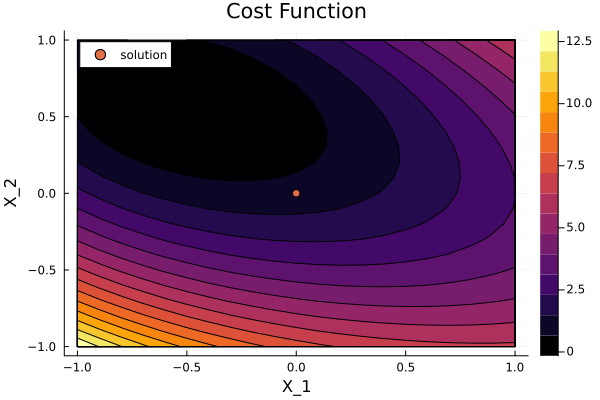

In [166]:
let
    Q = [1.65539 2.89376; 2.89376 6.51521]
    q = [2; -3]

    f(x) = 0.5 * x' * Q * x + q' * x + exp(-1.3 * x[1] + 0.3 * x[2]^2) # cost function 

    contour(-1:0.1:1, -1:0.1:1, (x1, x2) -> f([x1; x2]), title="Cost Function",
        xlabel="X_1", ylabel="X_2", fill=true)

    scatter!([Rp_global[1][6]], [Rp_global[2][6]], label="solution")
end

## Note on Newton's method for unconstrained optimization
To solve the above problem, we used Newton's method on the following equation:

$$ \nabla f(x) = 0 \quad \quad \text{stationarity}, $$

Which results in the following Newton steps:

$$ \Delta x = - \bigg[ \frac{\partial \nabla f(x)}{x} \bigg]^{-1} \nabla f(x_k). $$

The jacobian of the gradient of $f(x)$ is the same as the hessian of $f(x)$ (write this out and convince yourself). This means we can rewrite the Newton step as the equivalent expression:

$$ \Delta x = - [\nabla^2f(x)]^{-1} \nabla f(x_k) $$

What is the interpretation of this? Well, if we take a second order Taylor series of our cost function, and minimize this quadratic approximation of our cost function, we get the following optimization problem:

$$ \min_{\Delta x} \quad \quad f(x_k) + [\nabla f(x_k)^T] \Delta x + \frac{1}{2} \Delta x^T [\nabla^2f(x_k)] \Delta x $$

Where our optimality condition is the following:

$$ \nabla f(x_k)^T +  [\nabla^2f(x_k)] \Delta x = 0 $$ 

And we can solve for $\Delta x$ with the following:

$$ \Delta x = - [\nabla^2f(x)]^{-1} \nabla f(x_k) $$

Which is our Newton step. This means that Newton's method on the stationary condition is the same as minimizing the quadratic approximation of the cost function at each iteration. 